In [ ]:
import Pkg
Pkg.activate("../../");

In [2]:
import Revise
import GLRenderer as GL
import Images as I
import MiniGSG as S
import Rotations as R
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN
import InverseGraphics as T
import NearestNeighbors
import LightGraphs as LG
import StaticArrays
import ProgressMeter
using Distributions
import Gen
using Plots
using ProgressMeter
try
    import MeshCatViz as V
catch
    import MeshCatViz as V    
end

In [3]:
# # Initialize the renderer
V.setup_visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


Process(`cmd.exe /C 'start http://127.0.0.1:8700'`, ProcessExited(0))

In [4]:
# Loading the YCB object models
YCB_DIR = joinpath(dirname(dirname(pwd())),"data")
world_scaling_factor = 10.0
id_to_cloud, id_to_shift, id_to_box  = T.load_ycbv_models_adjusted(YCB_DIR, world_scaling_factor);
all_ids = sort(collect(keys(id_to_cloud)));
names = T.load_ycb_model_list(YCB_DIR)

21-element Vector{String}:
 "002_master_chef_can"
 "003_cracker_box"
 "004_sugar_box"
 "005_tomato_soup_can"
 "006_mustard_bottle"
 "007_tuna_fish_can"
 "008_pudding_box"
 "009_gelatin_box"
 "010_potted_meat_can"
 "011_banana"
 "019_pitcher_base"
 "021_bleach_cleanser"
 "024_bowl"
 "025_mug"
 "035_power_drill"
 "036_wood_block"
 "037_scissors"
 "040_large_marker"
 "051_large_clamp"
 "052_extra_large_clamp"
 "061_foam_brick"

In [5]:
# Initialize the canera intrinsics and renderer that will render using those intrinsics.
camera = GL.CameraIntrinsics()
camera = T.scale_down_camera(camera, 5.5)
camera_pose = IDENTITY_POSE

renderer = GL.setup_renderer(camera, GL.DepthMode())
resolution = 0.05

@show camera;

gl_version_for_shaders = "460"
true
camera = GLRenderer.CameraIntrinsics
  width: Int64 116
  height: Int64 87
  fx: Float64 116.36363636363636
  fy: Float64 116.36363636363636
  cx: Float64 58.18181818181818
  cy: Float64 43.63636363636363
  near: Float64 0.001
  far: Float64 100.0



In [6]:

# Load a cube (id = 1) and all ycb objects
# box_mesh = GL.box_mesh_from_dims([2.0, 2.0, 2.0])
# GL.load_object!(renderer, box_mesh)

for id in all_ids
    cloud = id_to_cloud[id]
    mesh = GL.mesh_from_voxelized_cloud(GL.voxelize(cloud, resolution), resolution);
    GL.load_object!(renderer, mesh)
end

@show length(all_ids)

length(all_ids) = 21


21

## introductory visualizations
to get a better sense of resolution effect on likelihood + qualitative results 

true


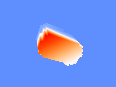

names[i] = "010_potted_meat_can"


"010_potted_meat_can"

In [34]:
#########
# radius scaling
#########
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,100.0)

i = 9 #rand(all_ids)
pose = Pose([0.0, 0.0, 3.0], R.RotXYZ(0.4, -0.2, 0.4))

# Reset the intrinsics inside of the renderer.
GL.set_intrinsics!(renderer, camera) 

# And render the same image as above.
gt_depth_image = GL.gl_render(renderer, [i], [pose], camera_pose)
IJulia.display(GL.view_depth_image(gt_depth_image))

# Create point cloud corresponding to that rendered depth image.
gt_cloud = GL.depth_image_to_point_cloud(gt_depth_image, camera)
# print(size(gt_cloud))


@show names[i]

# radius = 0.01  # "tight" radius
# sampled_cloud = Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds)
# # Visualize that point cloud.
# # V.setup_visualizer()
# # V.viz(sampled_cloud)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))

 
# radius = float(1)  # "loose" radius (can still pick out general shape)
# sampled_cloud = Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds)
# # Visualize that point cloud.
# # V.setup_visualizer()
# # V.viz(sampled_cloud)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))

 
# radius = float(10)  # very loose radius; points on a sphere (w/ some concentration on center with shape of obj)
# sampled_cloud = Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds)
# # # Visualize that point cloud.
# # V.setup_visualizer()
# # V.viz(sampled_cloud)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))

In [8]:
# ########
# # camera downscaling
# ########
# using IJulia

# final = 24
# for downscale_factor=1:3.0:final
#     println("scale down by $downscale_factor")
    
#     # scale camera according to resolution; reset renderer
#     scaled_camera = GL.scale_down_camera(camera, downscale_factor)
        
#     # Set the renderer to now have those scaled down intrinsics.
#     GL.set_intrinsics!(renderer, scaled_camera)
 
#     d = GL.gl_render(renderer, [i], [pose], IDENTITY_POSE)

#     img = GL.view_depth_image(d)
#     img = I.imresize(img, (camera.height, camera.width));
#     IJulia.display(img)
  
#     # revert intrinsics
#     GL.set_intrinsics!(renderer, camera)

# end


# Intro demo of coarse-to-fine with particle filtering

## Particle Filtering + Orientation enumeration

### Orientation enumeration

In [9]:
function fibonacci_sphere(samples)
    points = []
    phi = π * (3. - sqrt(5.))
 
    for i in 0:(samples-1)
        y = 1 - (i / Float64(samples - 1)) * 2
        #@show y
        radius = sqrt(1 - y * y)

        theta = phi * i

        x = cos(theta) * radius
        z = sin(theta) * radius

        push!(points, (x, y, z))
    end
    return points
end

fibonacci_sphere (generic function with 1 method)

In [10]:
unit_sphere_directions = fibonacci_sphere(150);
other_rotation_angle = collect(0:0.20:(2*π));

rotations_to_enumerate_over = [
    let
        T.geodesicHopf_select_axis(StaticArrays.SVector(dir), ang, 1)
    end
    for dir in unit_sphere_directions, 
        ang in other_rotation_angle
];
num_rotations_to_enumerate_over = length(rotations_to_enumerate_over);

### Helpers

In [11]:
function viz_trace(trace)
    V.setup_visualizer()
#     V.reset_visualizer()
    V.viz(Gen.get_retval(trace).voxelized_cloud  ./ 10.0; color=I.colorant"red", channel_name=:gen);
    V.viz(Gen.get_retval(trace).obs_cloud ./ 10.0; color=I.colorant"blue", channel_name=:obs);
end

viz_trace (generic function with 1 method)

In [12]:
# Helper function to get point cloud from the object ids, object poses, and camera pose
# (see demo.jl)
function get_cloud(poses, ids, renderer, camera_pose)
#     @show poses, ids
    depth_image = GL.gl_render(renderer, ids, poses, camera_pose)
    cloud = GL.depth_image_to_point_cloud(depth_image, renderer.camera_intrinsics)
    if isnothing(cloud)
        cloud = zeros(3,1)
    else
        cloud = T.move_points_to_frame_b(cloud, camera_pose)
    end
    cloud
end

get_cloud (generic function with 1 method)

In [13]:
function icp_move(trace, i, inf_radius, renderer, cam_pose; iterations=10, unexplained_radius=0.2, crazy_pose=Pose([-100.0,-100.0,-100.0]))
    # get_cloud_func needs to give the points in the world frame
    get_cloud_func = (poses, ids, cam_pose, i) -> get_cloud(poses, ids, renderer, cam_pose)  
    id = Gen.get_choices(trace)[:id]  
    addr = T.floating_pose_addr(1)
    
#     crazy_voxelized_cloud = GL.voxelize(get_cloud([crazy_pose], [id], renderer, cam_pose), v_resolution(inf_radius))
#     observations = Gen.choicemap(T.obs_addr() => crazy_voxelized_cloud, :id => id)
#     t, _,_,_ = Gen.update(trace, observations)
    
    t, = Gen.update(trace, Gen.choicemap(T.floating_pose_addr(1) => crazy_pose))
    obs_cloud = T.move_points_to_frame_b(
            T.get_unexplained_obs_cloud(t, unexplained_radius)[1], cam_pose)
    refined_pose = trace[addr]
    refined_pose = T.icp_object_pose(
        refined_pose,
        obs_cloud,
        p -> get_cloud_func([p], [id], cam_pose, 1) 
    )

    acceptances = false
     
    for _ in 1:iterations
        trace, acc = T.pose_mixture_move(
            trace, addr, [trace[addr], refined_pose], [0.5, 0.5], 1e-2, 5000.0
        )
        acceptances = acc || acceptances
    end
    
    trace, acceptances, refined_pose
end


icp_move (generic function with 1 method)

In [14]:
function icp_move_no_unexplained(trace, i, inf_radius, renderer, cam_pose; iterations=10)
    # get_cloud_func needs to give the points in the world frame
    get_cloud_func = (poses, ids, cam_pose, i) -> get_cloud(poses, ids, renderer, cam_pose)  
    id = Gen.get_choices(trace)[:id]  
    addr = T.floating_pose_addr(1)
    
    obs_cloud = T.move_points_to_frame_b(T.get_obs_cloud(trace), cam_pose)
    
    refined_pose = trace[addr]
    refined_pose = T.icp_object_pose(
        refined_pose,
        obs_cloud,
        p -> T.voxelize(get_cloud_func([p], [id], cam_pose, 1),inf_radius)
    )

    acceptances = false
     
    for _ in 1:iterations
        trace, acc = T.pose_mixture_move(
            trace, addr, [trace[addr], refined_pose], [0.5, 0.5], 1e-2, 5000.0
        )
        acceptances = acc || acceptances
    end
    
    trace, acceptances, refined_pose
end

icp_move_no_unexplained (generic function with 1 method)

In [15]:
"""Selecting from a set of traces over all enumerated angles, generate a set of initial particles"""
Gen.@gen function generate_initial_pf_state(scored_traces, num_particles, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    # unpack traces
    traces = (t -> t[1]).(scored_traces)
    log_weights = (t -> t[1].score).(scored_traces)#(t -> t[2]).(scored_traces)  
    
    _, norm_log_weights = Gen.normalize_weights(log_weights)       
    
    # sample initial set of particles
    selected_traces = Vector{Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}}}(undef, num_particles)
    selected_log_weights = Vector{Float64}(undef, num_particles)
    for i=1:num_particles
        trace_idx = Gen.random(Gen.categorical, exp.(norm_log_weights))   
        selected_traces[i] = traces[trace_idx]
        selected_log_weights[i] = norm_log_weights[trace_idx]
    end
    
    println("Initial particle state computed"); flush(stdout)

#     # visualize pdf of initial weights (?)
#     plot(selected_log_weights, seriestype=:stephist, fmt = :png)
    
    # see intermediate results
    top_n = max(10, num_particles-1)
    _, norm_log_weights = Gen.normalize_weights(selected_log_weights)
    p = sortperm(norm_log_weights)[end-top_n:end]; 

    best_trace = selected_traces[argmax(norm_log_weights)];
    viz_trace(best_trace);
    println("top$top_n traces:")
    for idx in p
       println("curr_weight=", norm_log_weights[idx], " ori=", R.params(Gen.get_retval(selected_traces[idx]).ori), " id=", Gen.get_retval(selected_traces[idx]).id) 
    end
    flush(stdout)
    
    return Gen.ParticleFilterState{U}(selected_traces, Vector{U}(undef, num_particles), selected_log_weights, 0., collect(1:num_particles))

end

generate_initial_pf_state

In [53]:
"""adapted from gen pf_step:
Perform a particle filter update, where the model arguments are adjusted, new observations are added, and the default proposal is used for new latent state.
"""
function particle_filter_step!(state::Gen.ParticleFilterState{U}, new_args::Tuple, argdiffs::Tuple,
        observations) where {U}    
    radius, renderer = new_args
    log_incremental_weights = Vector{Float64}(undef, num_particles) 
    radius::Float64 = new_args[1]
    
    @showprogress for i=1:num_particles
    ## do mh, drift moves, etc. tune particle before update (i.e. new likelihood)
        state.traces[i], acc, _ = icp_move_no_unexplained(state.traces[i], Gen.get_retval(state.traces[i]).id, 
                                            radius, renderer, camera_pose; iterations=15)

        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.001, 100.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 100.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 500.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.001, 1000.0)
        state.traces[i], acc = T.drift_move(state.traces[i], T.floating_pose_addr(1), 0.0005, 1000.0)

        
        # evolve the particle (with new radius involved in new_args)
        (state.new_traces[i], increment, _, discard) = Gen.update(
            state.traces[i], new_args, argdiffs, observations)
#         if !isempty(discard)
#             error("Choices were updated or deleted inside particle filter step: $discard")
#         end
        log_incremental_weights[i] = increment
        state.log_weights[i] += increment
    end
    
    # swap references
    tmp = state.traces
    state.traces = state.new_traces
    state.new_traces = tmp

    return log_incremental_weights
end

particle_filter_step!

In [17]:
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,300.0)

v_resolution = radius -> radius * 0.5  # distance between two points on the pointcloud 

"""sample point clouds at the given camera resolution and radius"""
Gen.@gen function model(radius, renderer)
    
    # sample object id
    i = {:id} ~ Gen.categorical(fill(1.0/num_candidate_objs, (num_candidate_objs,)))
    
    # sample pose
    p = {T.floating_pose_addr(1)} ~ T.uniformPose(-0.001, 0.001, -0.001, 0.001, 4.999, 5.001)
    
    gt_cloud = get_cloud([p], [i], renderer, camera_pose)    
    voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(radius))
    obs_cloud = {T.obs_addr()} ~ T.uniform_mixture_from_template(voxelized_cloud, 0.0001, radius, bounds)
#     print("."); flush(stdout)
         
    (id=i, pose=p, ori=p.orientation, cloud=gt_cloud, voxelized_cloud=voxelized_cloud, rendered_clouds=[voxelized_cloud], obs_cloud=obs_cloud)

end
 
"""return scale down factor of camera given desired resolution"""
function scale_factor(resolution, final_resolution)
   return final_resolution-resolution+1 
end

scale_factor

### control resolution with radius (fixed camera intrinsics)

In [29]:
"""Particle filter on the evolution of agent knowledge over time; resolution control with radius"""


function particle_filter(renderer, init_radius::Float64, final_radius::Float64, scored_traces,
                        gt_obj_id::Int, gt_pose::Pose, num_particles::Int, num_samples::Int, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    
    # initialize renderer and particle filter
    GL.set_intrinsics!(renderer, camera)  
    gt_cloud = get_cloud([gt_pose], [gt_obj_id], renderer, camera_pose)
    gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))
#     V.setup_visualizer()
#     V.viz(gt_voxelized_cloud)
    println("\ninitializing particle filter at radius $init_radius") 
    flush(stdout)
    
    
    # initialize a state of initial particles with various rotations  
    state::Gen.ParticleFilterState{U} = generate_initial_pf_state(scored_traces, num_particles)
    
    
    # evolve over resolutions (modify sphere radius `r` of mixture point cloud likelihood)
    @assert(final_radius <= init_radius)
    step = -final_radius
    for radius in init_radius+step:step:final_radius
        println("\n========Radius=$radius========"); flush(stdout)
        Gen.maybe_resample!(state, ess_threshold=num_particles/3, verbose=true)  
        
        # update pf 
        observations = Gen.choicemap(T.obs_addr() => GL.voxelize(gt_cloud, v_resolution(radius)) 
                                    ,:id => gt_obj_id)
        current_log_weights = particle_filter_step!(state, (radius, renderer), (Gen.UnknownChange(),), observations)    
        
        # see intermediate results
        top_n = max(10, num_particles-1)
        _, norm_log_weights = Gen.normalize_weights(current_log_weights)
        p = sortperm(norm_log_weights)[end-top_n:end]; 
        
        best_trace = state.traces[argmax(norm_log_weights)];
        viz_trace(best_trace);
        println("top$top_n traces:")
        for idx in p
           println("weight=", norm_log_weights[idx], " ori=", R.params(Gen.get_retval(state.traces[idx]).ori), "  id=", Gen.get_retval(state.traces[idx]).id) 
        end
        flush(stdout)
        
    end;
    
    # normalize final weights
    log_total_weight, _ = Gen.normalize_weights(state.log_weights)
    return Gen.sample_unweighted_traces(state, num_samples)
    
end

particle_filter (generic function with 2 methods)

In [30]:
# Initialize the canera intrinsics and renderer that will render using those intrinsics.
GL.set_intrinsics!(renderer, camera)
 
final_radius = float(0.05)  # low to high "focus"
init_radius = final_radius * 5
camera_pose = IDENTITY_POSE


true


Pose⟨pos=[0, 0, 0], orientation=(w=1.0, x=0.0, y=0.0, z=0.0)⟩

In [40]:
function precompute_enumerations(gt_voxelized_cloud, gt_pose, init_radius, renderer, num_candidate_objs, rotations_to_enumerate_over)
    # initialize a state of initial particles with various rotations
    all_scored_traces = Nothing
    println("Enumerating over all objects, angles:")
    for obj_id=1:num_candidate_objs
        scored_traces = @showprogress map(orn -> 
                        Gen.generate(model, (init_radius, renderer),                 
                                    Gen.choicemap(T.obs_addr() => gt_voxelized_cloud, 
                                                :id => obj_id, 
                                                T.floating_pose_addr(1) => Pose(gt_pose.pos, orn))),
                                    rotations_to_enumerate_over[:]);
        
        if all_scored_traces == Nothing
            all_scored_traces = scored_traces
        else
            all_scored_traces = vcat(all_scored_traces, scored_traces)
        end
    end
    return all_scored_traces 
    
end 


# precompute enumeration; run the below code once and comment out
num_candidate_objs = 10 #length(all_ids)+1  #set to 1 for fixed object id

gt_obj_id = 7#rand(1:num_candidate_objs)
object = names[gt_obj_id]
println("Object id$gt_obj_id  $object")

tr, _ = Gen.generate(model, (init_radius, renderer), Gen.choicemap(:id => gt_obj_id))
gt_pose = T.Pose(pos=[0.0, 0.0, 5.0], orientation=Gen.get_retval(tr).ori)

gt_cloud = get_cloud([gt_pose], [gt_obj_id], renderer, camera_pose)
gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution(init_radius))

# enum_ori_traces_10 = precompute_enumerations(gt_voxelized_cloud, gt_pose, init_radius, renderer, num_candidate_objs, rotations_to_enumerate_over)

num_rotations_to_enumerate_over = length(enum_ori_traces)


precompute_enumerations (generic function with 1 method)

In [45]:
# precompute enumeration; run the below code once and comment out
num_candidate_objs = 21 #length(all_ids)+1  #set to 1 for fixed object id

gt_obj_id = rand(1:num_candidate_objs)
# gt_pose, enum_ori_traces = precompute_enumerations(gt_obj_id, init_radius, renderer, num_candidate_objs, rotations_to_enumerate_over)



4

In [51]:
# enum_ori_traces_full = enum_ori_traces
# gt_pose_full = gt_pose
# gt_obj_id_full = gt_obj_id

4

In [52]:
@show num_rotations_to_enumerate_over = length(enum_ori_traces)
@show gt_obj_id
num_particles = 20
num_samples = num_particles
@time pf_traces = particle_filter(renderer, init_radius, final_radius, 
                                    enum_ori_traces_full, gt_obj_id_full, gt_pose_full, num_particles, num_samples);


num_rotations_to_enumerate_over = length(enum_ori_traces) = 100800
gt_obj_id = 4
true

initializing particle filter at radius 0.25
Initial particle state computed
top19 traces:
curr_weight=-2.995732273553991 ori=[0.40996497674712196, 0.8054826471976271, -0.41213673480418045, -0.11519433462277356] id=10
curr_weight=-2.995732273553991 ori=[0.40996497674712196, 0.8054826471976271, -0.41213673480418045, -0.11519433462277356] id=10
curr_weight=-2.995732273553991 ori=[0.40996497674712196, 0.8054826471976271, -0.41213673480418045, -0.11519433462277356] id=10
curr_weight=-2.995732273553991 ori=[0.40996497674712196, 0.8054826471976271, -0.41213673480418045, -0.11519433462277356] id=10
curr_weight=-2.995732273553991 ori=[0.40996497674712196, 0.8054826471976271, -0.41213673480418045, -0.11519433462277356] id=10
curr_weight=-2.995732273553991 ori=[0.40996497674712196, 0.8054826471976271, -0.41213673480418045, -0.11519433462277356] id=10
curr_weight=-2.995732273553991 ori=[0.40996497674712196, 0.80

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8726
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


effective sample size: 19.999999999999996, doing resample: false
top19 traces:
weight=-26.088262945727553 ori=[0.4428766400442645, 0.7453789446745275, -0.45318406160010016, -0.20711039773663548]  id=4
weight=-16.228770708822463 ori=[0.4068302706101596, 0.7790662127985211, -0.4566518691196661, -0.1378913971955807]  id=4
weight=-16.153435171507407 ori=[0.4192733350249716, 0.7739299194408891, -0.4537660658779721, -0.13906368249433357]  id=4
weight=-15.095525813783606 ori=[0.4111847952542571, 0.7953489063887708, -0.4194980534811884, -0.14956123957561723]  id=4
weight=-10.58392796155584 ori=[0.419678744414805, 0.8037036782297382, -0.387649984015264, -0.16630585972649253]  id=4
weight=-8.289300929515338 ori=[0.4146759025484466, 0.801148433697454, -0.4189353621166647, -0.10343232279092723]  id=4
weight=-7.782639850692693 ori=[0.40996497674712196, 0.8054826471976271, -0.41213673480418045, -0.11519433462277356]  id=4
weight=-7.782639850692693 ori=[0.40996497674712196, 0.8054826471976271, -0.412

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8727
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


effective sample size: 3.2574875858349652, doing resample: true
top19 traces:
weight=-9.651447513741516 ori=[0.4449562149558956, 0.8094317271060225, -0.3564196766586027, -0.14070984335455045]  id=4
weight=-9.180766911593679 ori=[0.43280800472631326, 0.8264513637559977, -0.33210370821158375, -0.13914920546950657]  id=4
weight=-6.299226447200539 ori=[0.4211300646035512, 0.8240853051887683, -0.3597258384097971, -0.11887051627427266]  id=4
weight=-6.299226447200539 ori=[0.4211300646035512, 0.8240853051887683, -0.3597258384097971, -0.11887051627427266]  id=4
weight=-6.299226447200539 ori=[0.4211300646035512, 0.8240853051887683, -0.3597258384097971, -0.11887051627427266]  id=4
weight=-6.000783322274657 ori=[0.4309136256570496, 0.7910988102435556, -0.4066290207216485, -0.15208208034242643]  id=4
weight=-4.043608836161525 ori=[0.4533555482481169, 0.7877062732392954, -0.40733544166244884, -0.0898076385268403]  id=4
weight=-4.043608836161525 ori=[0.4533555482481169, 0.7877062732392954, -0.407335

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8728
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


effective sample size: 7.5466724801656815, doing resample: false
top19 traces:
weight=-68.47564847419272 ori=[0.42606475839430286, 0.7844217800539234, -0.4293050052823533, -0.13728985785904718]  id=4
weight=-64.56704379598455 ori=[0.4449562149558956, 0.8094317271060225, -0.3564196766586027, -0.14070984335455045]  id=4
weight=-63.79833483785933 ori=[0.4211300646035512, 0.8240853051887683, -0.3597258384097971, -0.11887051627427266]  id=4
weight=-63.79833483785933 ori=[0.4211300646035512, 0.8240853051887683, -0.3597258384097971, -0.11887051627427266]  id=4
weight=-57.65133134617702 ori=[0.4533555482481169, 0.7877062732392954, -0.40733544166244884, -0.0898076385268403]  id=4
weight=-57.65133134617702 ori=[0.4533555482481169, 0.7877062732392954, -0.40733544166244884, -0.0898076385268403]  id=4
weight=-34.229923896183436 ori=[0.428208951533938, 0.8196827328095248, -0.3739236954880297, -0.0702736174726343]  id=4
weight=-20.684071618039752 ori=[0.41291763600889086, 0.8142068323488021, -0.39472

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8729
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


effective sample size: 8.000093401835915, doing resample: false
top19 traces:
weight=-1915.4947260304564 ori=[0.428208951533938, 0.8196827328095248, -0.3739236954880297, -0.0702736174726343]  id=4
weight=-1803.5835054381944 ori=[0.4100336522000608, 0.8331144129306834, -0.3512056222286068, -0.1201972959165891]  id=4
weight=-1507.1293214224695 ori=[0.4211300646035512, 0.8240853051887683, -0.3597258384097971, -0.11887051627427266]  id=4
weight=-1385.4928941102755 ori=[0.43280800472631326, 0.8264513637559977, -0.33210370821158375, -0.13914920546950657]  id=4
weight=-1224.6927804462568 ori=[0.4449562149558956, 0.8094317271060225, -0.3564196766586027, -0.14070984335455045]  id=4
weight=-610.9368026508016 ori=[0.43313857336678385, 0.8090595823120836, -0.38422102197990143, -0.10093450747640426]  id=4
weight=-494.958825395547 ori=[0.44256541636198177, 0.7831257423513148, -0.4302040654492333, -0.07598938069230533]  id=4
weight=-376.5494768378954 ori=[0.4533555482481169, 0.7877062732392954, -0.40

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8730
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


LoadError: MethodError: no method matching params(::Rotations.RotMatrix3{Float64})
[0mClosest candidates are:
[0m  params([91m::Rotations.Angle2d[39m) at C:\Users\karen\.julia\packages\Rotations\oI2Iq\src\core_types.jl:152
[0m  params([91m::Rotations.QuatRotation[39m) at C:\Users\karen\.julia\packages\Rotations\oI2Iq\src\unitquaternion.jl:228
[0m  params([91m::Rotations.RotXZY[39m) at C:\Users\karen\.julia\packages\Rotations\oI2Iq\src\euler_types.jl:548
[0m  ...

In [54]:
# @show num_rotations_to_enumerate_over
# @show gt_obj_id
# num_particles = 20
# num_samples = num_particles
# @time pf_traces = particle_filter(renderer, init_radius, final_radius, 
#                                     enum_ori_traces_10, 7, gt_pose_10, num_particles, num_samples);


In [24]:
gt_obj_id

7

In [25]:
# p = R.params(Gen.get_retval(pf_traces[1]).ori)
# @show R.QuatRotation(p)
# @show Gen.get_retval(pf_traces[1]).ori

# p1 = R.params(gt_pose.orientation)
# @show R.QuatRotation(p1)
# @show gt_pose.orientation

trace_info = [(Gen.get_score(trace), R.params(Gen.get_retval(trace).ori)) for trace in pf_traces]

import JLD
JLD.save("pf_traces.jld", "trace_info", trace_info, "gt_pose_pos", gt_pose.pos, 
    "gt_pose_ori", R.params(gt_pose.orientation), "gt_obj_id", gt_obj_id)

LoadError: UndefVarError: pf_traces not defined

### visualization of the enumerated posterior at multiple different resolutions

In [26]:

# # save("../pf_traces.jld", "x", [1])
# save("../pf_traces.jld", "pf_traces", d)

In [27]:
# xyz = [
#     rotations_to_enumerate_over[i,1] * [1, 0, 0]
#     for i in 1:size(rotations_to_enumerate_over)[1] 
# ];
# log_weights_xyz = zeros(size(rotations_to_enumerate_over)[1])
# weights_xyz = exp.(log_weights_xyz)
# order = sortperm(weights_xyz,rev=true)
# weights_xyz = weights_xyz[order]
# xyz = xyz[order]
# weights_xyz


In [28]:
# using PyCall
# using PyPlot

# plt = pyimport("matplotlib.pyplot")
# mpl_toolkits = pyimport("mpl_toolkits")
# x = range(0;stop=2*pi,length=1000); y = sin.(3*x + 4*cos.(2*x));
# plot(x, y, color="red", linewidth=2.0, linestyle="--")
# # plt.show()

# function run_viz(x, y, z, c)
#     fig = plt.figure(figsize=(9, 6))
#     ax = plt.axes(projection="3d")
#     ax.scatter3D(x, y, z, c=c)
#     p = ax.set_title("3D scatterplot", pad=25, size=15)
#     ax.set_xlabel("X") 
#     ax.set_ylabel("Y") 
#     ax.set_zlabel("Z")
#     plt.show()
# end



# # PyCall.py"""
# # import matplotlib.pyplot as plt
# # from mpl_toolkits import mplot3d
# # def run_viz(x,y,z,c):
# #     fig = plt.figure(figsize=(9, 6))
# #     ax = plt.axes(projection='3d')
# #     ax.scatter3D(x, y, z, c=c)
# #     p = ax.set_title("3D scatterplot", pad=25, size=15)
# #     ax.set_xlabel("X") 
# #     ax.set_ylabel("Y") 
# #     ax.set_zlabel("Z")
# #     plt.show()
# # """

# run_viz( (i->i[1]).(xyz), (i->i[2]).(xyz), (i->i[3]).(xyz), weights_xyz)